In [ ]:
#1. 패키지 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#2. GPU 사용 체크
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True

In [ ]:
# 3. mnist 데이터 다운로드
#전처리 요구사항이 2개여서 compose로 묶어주었음
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('data/',train=True,transform=transformation,download=True)
test_dataset = datasets.MNIST('data/',train=False,transform=transformation,download=True)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4933831.57it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 158777.57it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1493244.43it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2839548.18it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
#4. 네트워크 정의
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x,p=0.1, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [ ]:
#5. 모델 불러오기
model = Net()
if is_cuda:
    model.cuda()

In [ ]:
#6. 최적화 함수
optimizer = optim.SGD(model.parameters(),lr=0.01)

In [ ]:
#7. 훈련 데이터 변수 준비
data , target = next(iter(train_loader))

In [ ]:
#8. 훈련 및 검증 함수
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)

        #running_loss += F.nll_loss(output,target,size_average=False).data[0]
        running_loss += F.nll_loss(output,target,reduction='sum').item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()

    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)

    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [ ]:
#9. 훈련
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.64 and training accuracy is 48183/60000     80.31
validation loss is  0.18 and validation accuracy is 9443/10000     94.43
training loss is  0.22 and training accuracy is 56164/60000     93.61
validation loss is  0.12 and validation accuracy is 9641/10000     96.41
training loss is  0.17 and training accuracy is 57061/60000      95.1
validation loss is 0.082 and validation accuracy is 9747/10000     97.47
training loss is  0.14 and training accuracy is 57492/60000     95.82
validation loss is 0.071 and validation accuracy is 9786/10000     97.86
training loss is  0.12 and training accuracy is 57779/60000      96.3
validation loss is 0.061 and validation accuracy is 9796/10000     97.96
training loss is  0.11 and training accuracy is 58003/60000     96.67
validation loss is 0.052 and validation accuracy is 9837/10000     98.37
training loss is   0.1 and training accuracy is 58185/60000     96.97
validation loss is 0.048 and validation accuracy is 9848/10000     98.48

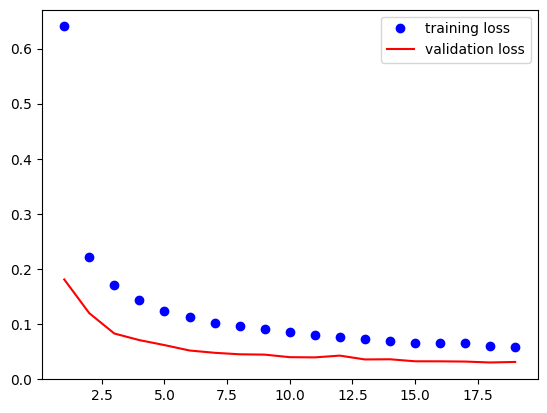

In [ ]:
#10. 훈련 데이터와 검증 데이터의 손실 그래프
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

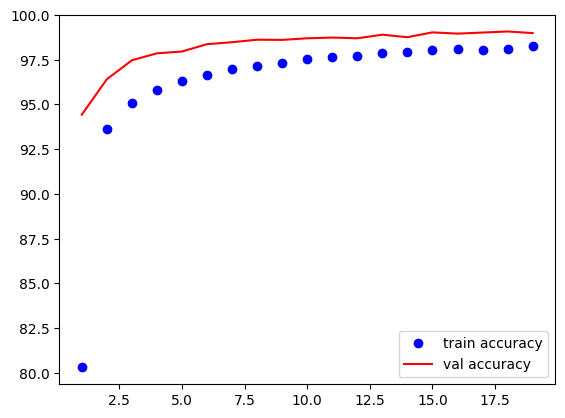

In [ ]:
#11. 훈련 데이터와 검증 데이터의 정확도 그래프
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()



```
transforms.Compose와 transforms.ToTensor(), transforms.Normalize()는
PyTorch에서 이미지 전처리 작업을 효율적으로 수행하기 위해 사용됨:
```


코드 분석:
```
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
```

```
1. transforms.Compose([...])
 - Compose는 여러 전처리(transformation) 작업을 순차적으로 적용할 수 있게 해주는 함수.
 - 이 예시에서는 ToTensor와 Normalize 변환이 차례대로 적용

2. transforms.ToTensor()
 - 이미지를 텐서(Tensor)로 변환
 - 이미지는 일반적으로 [0, 255] 범위의 픽셀 값
   - ToTensor()는 이를 [0, 1] 범위로 정규화(Normalization)
   - 이미지의 각 픽셀 값을 float 타입의 값으로 변환
     - 신경망이 학습할 수 있도록 준비

3. transforms.Normalize((0.1307,), (0.3081,))
 - 이미지의 각 채널에 대해 정규화를 수행합니다.
 - (0.1307,)는 평균(mean)
 - (0.3081,)는 표준편차(standard deviation)
 - 이미지 채널마다 적용되는데, 여기서는 단일 채널(흑백 이미지)에서
   사용됨.
```
 정규화는 아래와 같이 이루어짐

 Normalized Value = (Tensor Value - mean) / std

```
 - 텐서의 값에서 평균을 빼고, 표준편차로 나누어 각 채널을 정규화함.

 - 예시 사용:
   - MNIST 데이터셋 같은 흑백 이미지에 자주 사용
   - MNIST 데이터셋의 픽셀 평균값이 0.1307, 표준편차가 0.3081이므로, 해당 데이터에 맞게 이미지를 정규화하는 것.

요약:
 - transforms.ToTensor()
   - 이미지를 텐서로 변환하고 [0, 1] 범위로 값을 스케일
 - transforms.Normalize((0.1307,), (0.3081,))
   - 평균과 표준편차를 기준으로 이미지 정규화
 - transforms.Compose([...])
   - 두 변환을 차례대로 적용하여, 데이터를 신경망에 입력할 수 있도록 준비함.

```

